Sarsa 嗯 收敛不到最优策略 而且要大量数据

Optimal value function:
[[-2.  -1.9 -1.6 -1.  -1.3]
 [-1.  -0.3  1.5  1.  -0.8]
 [-0.1  1.1 14.1  3.8  0.1]
 [ 0.9 12.9 13.1 13.5  4.1]
 [-0.4  4.7 15.3  2.4  1.2]]
Optimal policy:


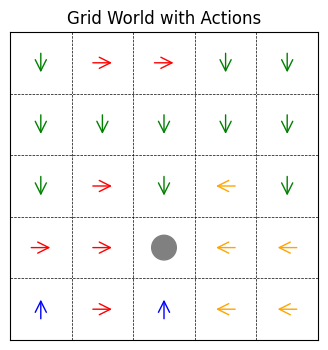

In [277]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy



class Policy:
    """ 
    Policy class defines an upgradeable policy for a grid world.
    """

    def __init__(self, grid_size):
        # Actions: 0 ↑, 1 →, 2 ↓, 3 ←, 4 stop
        self.action_list = [0, 1, 2, 3, 4]
        self.action_probability = {(x, y):[0.2, 0.2, 0.2, 0.2, 0.2] for x in range(grid_size) for y in range(grid_size)}
        self.policy = {(i, j): random.randint(0, 4) for i in range(grid_size) for j in range(grid_size)}

    def upgrade(self, x, y, List):
        self.policy[x, y] = List
    
    def get_action(self, x, y):
        return random.choices(self.action_list, self.action_probability[x, y])[0]


class Reward:
    """
    Reward class defines the reward structure for a grid world.
    """

    def __init__(self, grid_size):
        self.grid_size = grid_size
        self.R = np.zeros((grid_size, grid_size))
        # Terminal states
        self.R[3, 2] = 10
        # Forbidden states
        self.R[1, 1] = self.R[1, 2] = self.R[2, 2] = self.R[3, 1] = self.R[3, 3] = self.R[4, 1] = -1

    def __call__(self, state, action, next_state):
        x, y = state
        x_n, y_n = next_state
        # Boundary conditions and forbidden states
        if x == 0 and action == 0:
            return -1  # 最上面往上走
        elif x == self.grid_size - 1 and action == 2:
            return -1  # 最下面往下走
        elif y == 0 and action == 3:
            return -1  # 最左边往左走
        elif y == self.grid_size - 1 and action == 1:
            return -1  # 最右边往右走
        elif (x == 0 and y == 0 and action == 3) \
                or (x == 0 and y == self.grid_size - 1 and action == 1) \
                or (x == self.grid_size - 1 and y == 0 and action == 3) \
                or (x == self.grid_size - 1 and y == self.grid_size - 1 and action == 1):
            return -1
        else:
            return self.R[x_n, y_n]


def get_next_state(state, action, grid_size):
    """
    Calculate the next state given the current state and action.
    """
    x, y = state
    if action == 0:  # up
        return (max(x - 1, 0), y)
    elif action == 1:  # right
        return (x, min(y + 1, grid_size - 1))
    elif action == 2:  # down
        return (min(x + 1, grid_size - 1), y)
    elif action == 3:  # left
        return (x, max(y - 1, 0))
    elif action == 4:  # stop
        return (x, y)


def Sarsa(grid_size, gamma, alpha, epsilon, max_iterations, epochs):
    """
    Perform policy iteration to find the optimal policy and value function.
    """
    policy = Policy(grid_size)
    R = Reward(grid_size)
    V = np.zeros((grid_size, grid_size))
    Q_pi = np.zeros((grid_size, grid_size, 5))
    
    for epoch in range(epochs):
        state = (random.choice(range(grid_size)), random.choice(range(grid_size)))
        for _ in range(max_iterations):
            action = policy.get_action(state[0], state[1])
            next_state = get_next_state(state, action, 5)
            r = R(state, action, next_state)
            next_action = policy.get_action(next_state[0], next_state[1])
            # 积累一条Exp
            Exp=[state, action, r, next_state, next_action]
            # update q-value
            xt, yt = Exp[0]
            xn, yn = Exp[3]
            target = Q_pi[xt, yt, Exp[1]] - (Exp[2] + gamma*Q_pi[xn, yn, Exp[4]])
            Q_pi[xt, yt, Exp[1]] = Q_pi[xt, yt, Exp[1]] - alpha*target     
            # Policy improvement
            update_list = np.ones(5)*epsilon/5
            update_list[np.argmax(Q_pi[xt, yt, :])] = 1-4*epsilon/5
            policy.upgrade(xt, yt, update_list)
            V[xt, yt] = np.max(Q_pi[xt, yt, :])
            if state == (3,2):
                break
            state = next_state
    return V, policy


def draw_grid(grid_size, policy):
    """
    绘制网格并根据动作绘制形状。

    :param grid_size: 网格的大小
    :param policy: 每个状态的动作策略
    """
    fig, ax = plt.subplots(figsize=(4, 4))

    # 绘制网格
    for i in range(grid_size + 1):
        ax.axhline(i, color='k', linestyle='--', linewidth=0.5)
        ax.axvline(i, color='k', linestyle='--', linewidth=0.5)

    # 绘制每个网格单元中的动作
    for (x, y), action in policy.policy.items():
        action = np.argmax(action)
        center_x, center_y = y + 0.5, grid_size - x - 0.5  # y + 0.5, grid_size - x - 0.5 确保中心位置正确
        if action == 0:  # ↑
            ax.add_patch(patches.FancyArrowPatch((center_x, center_y - 0.2), (center_x, center_y + 0.2),
                                                 mutation_scale=20, color='blue', arrowstyle='->'))
        elif action == 1:  # →
            ax.add_patch(patches.FancyArrowPatch((center_x - 0.2, center_y), (center_x + 0.2, center_y),
                                                 mutation_scale=20, color='red', arrowstyle='->'))
        elif action == 2:  # ↓
            ax.add_patch(patches.FancyArrowPatch((center_x, center_y + 0.2), (center_x, center_y - 0.2),
                                                 mutation_scale=20, color='green', arrowstyle='->'))
        elif action == 3:  # ←
            ax.add_patch(patches.FancyArrowPatch((center_x + 0.2, center_y), (center_x - 0.2, center_y),
                                                 mutation_scale=20, color='orange', arrowstyle='->'))
        elif action == 4:  # stop
            ax.add_patch(patches.Circle((center_x, center_y), 0.2, color='gray'))

    # 设置轴的属性
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Grid World with Actions')

    plt.show()


def main():
    grid_size = 5
    gamma = 0.9
    update_iterations = 500
    alpha = 0.1
    epsilon = 0.1
    epochs = 500

    V, policy = Sarsa(grid_size, gamma, alpha, epsilon, update_iterations, epochs)
    print("Optimal value function:")
    print(np.round(V, decimals=1))
    print("Optimal policy:")
    draw_grid(grid_size, policy)


if __name__ == "__main__":
    main()